In [7]:
!pip install ucimlrepo scikit-learn matplotlib seaborn pandas numpy torch

In [8]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report)
import torch
import torch.nn as nn
from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Fetch Chronic Kidney Disease dataset
chronic_kidney_disease = fetch_ucirepo(id=336)

# Extract features and target
X = chronic_kidney_disease.data.features
y = chronic_kidney_disease.data.targets

print(f"Dataset shape: {X.shape}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")

print("CLASS DISTRIBUTION")
print(y.value_counts())
print(f"\nClass balance: {y.value_counts(normalize=True)}")

print("FEATURE NAMES")
print(X.columns.tolist())

print("MISSING VALUES SUMMARY")
missing_summary = pd.DataFrame({
    'Feature': X.columns,
    'Missing_Count': X.isnull().sum(),
    'Missing_Percentage': (X.isnull().sum() / len(X) * 100).round(2)
}).sort_values('Missing_Count', ascending=False)
print(missing_summary.head(15))

print("FEATURE TYPES")
print(X.dtypes.value_counts())

Loading Chronic Kidney Disease dataset...
Dataset shape: (400, 24)
Number of samples: 400
Number of features: 24
CLASS DISTRIBUTION
class 
ckd       248
notckd    150
ckd\t       2
Name: count, dtype: int64

Class balance: class 
ckd       0.620
notckd    0.375
ckd\t     0.005
Name: proportion, dtype: float64
FEATURE NAMES
['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
MISSING VALUES SUMMARY
     Feature  Missing_Count  Missing_Percentage
rbc      rbc            152               38.00
rbcc    rbcc            131               32.75
wbcc    wbcc            106               26.50
pot      pot             88               22.00
sod      sod             87               21.75
pcv      pcv             71               17.75
pc        pc             65               16.25
hemo    hemo             52               13.00
su        su             49               12.25
sg      

In [12]:
# Create a copy for preprocessing
df = X.copy()
df['class'] = y

print("\n" + "="*80)
print("FIXING DATA QUALITY ISSUES")
print("="*80)

# FIX 1: Clean target variable (remove whitespace)
print("\nBefore cleaning:")
print(df['class'].value_counts())

df['class'] = df['class'].str.strip()  # Remove leading/trailing whitespace including \t

print("\nAfter cleaning:")
print(df['class'].value_counts())

# FIX 2: Clean feature names (some have \t in values too)
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.strip()

print("\n✓ Data cleaned")

print("\n" + "="*80)
print("PREPROCESSING: Identifying Feature Types")
print("="*80)

# Numerical features (continuous) - based on the actual data
numerical_features = ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot',
                     'hemo', 'pcv', 'wbcc', 'rbcc']  # Note: wbcc and rbcc (not wc, rc)

# Categorical features (nominal/binary)
categorical_features = ['sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba',
                       'htn', 'dm', 'cad', 'appet', 'pe', 'ane']

print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Verify all features are accounted for
all_features = numerical_features + categorical_features
missing_features = set(X.columns) - set(all_features)
if missing_features:
    print(f"\n⚠️ Warning: Features not categorized: {missing_features}")

print(f"\n{'='*80}")
print("STEP 1: Handle Missing Values")
print(f"{'='*80}")
print(f"Total missing values before imputation: {df[all_features].isnull().sum().sum()}")

# For numerical features: Impute with median (robust to outliers)
from sklearn.impute import SimpleImputer

numerical_imputer = SimpleImputer(strategy='median')
df[numerical_features] = numerical_imputer.fit_transform(df[numerical_features])

# For categorical features: Impute with most frequent
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_features] = categorical_imputer.fit_transform(df[categorical_features])

print(f"Total missing values after imputation: {df[all_features].isnull().sum().sum()}")
print("✓ Missing values imputed")

print(f"\n{'='*80}")
print("STEP 2: Encode Categorical Features")
print(f"{'='*80}")

# Label encode categorical features
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    unique_vals = ', '.join([str(c) for c in le.classes_[:5]])  # Show first 5
    if len(le.classes_) > 5:
        unique_vals += '...'
    print(f"  {col:10s}: {len(le.classes_)} categories → [{unique_vals}]")

print("\n✓ Categorical features encoded")

print(f"\n{'='*80}")
print("STEP 3: Encode Target Variable")
print(f"{'='*80}")

# Encode target: 'ckd' → 1, 'notckd' → 0
target_encoder = LabelEncoder()
df['class_encoded'] = target_encoder.fit_transform(df['class'])

print(f"Target classes: {target_encoder.classes_}")
print(f"Target mapping:")
for cls, encoded in zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)):
    count = (df['class_encoded'] == encoded).sum()
    print(f"  {cls:10s} → {encoded} ({count} samples, {count/len(df)*100:.1f}%)")

# Separate features and target
X_processed = df[all_features].values
y_processed = df['class_encoded'].values

print(f"\n{'='*80}")
print("PREPROCESSING COMPLETE")
print(f"{'='*80}")
print(f"Final X shape: {X_processed.shape}")
print(f"Final y shape: {y_processed.shape}")
print(f"Feature composition:")
print(f"  - Numerical: {len(numerical_features)} features")
print(f"  - Categorical: {len(categorical_features)} features")
print(f"  - Total: {X_processed.shape[1]} features")
print(f"\nClass distribution:")
print(f"  - Class 0 (notckd): {(y_processed == 0).sum()} samples")
print(f"  - Class 1 (ckd): {(y_processed == 1).sum()} samples")
print(f"  - Imbalance ratio: {(y_processed == 1).sum() / (y_processed == 0).sum():.2f}:1")


FIXING DATA QUALITY ISSUES

Before cleaning:
class
ckd       248
notckd    150
ckd\t       2
Name: count, dtype: int64

After cleaning:
class
ckd       250
notckd    150
Name: count, dtype: int64

✓ Data cleaned

PREPROCESSING: Identifying Feature Types
Numerical features (11): ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']
Categorical features (13): ['sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']

STEP 1: Handle Missing Values
Total missing values before imputation: 1012
Total missing values after imputation: 0
✓ Missing values imputed

STEP 2: Encode Categorical Features
  sg        : 5 categories → [1.005, 1.01, 1.015, 1.02, 1.025]
  al        : 6 categories → [0.0, 1.0, 2.0, 3.0, 4.0...]
  su        : 6 categories → [0.0, 1.0, 2.0, 3.0, 4.0...]
  rbc       : 2 categories → [abnormal, normal]
  pc        : 2 categories → [abnormal, normal]
  pcc       : 2 categories → [notpresent, present]
  ba        : 2 categor

In [13]:
print("\n" + "="*80)
print("TRAIN-TEST SPLIT & STANDARDIZATION")
print("="*80)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed,
    test_size=0.2,
    random_state=42,
    stratify=y_processed
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTrain class distribution:")
print(f"  Class 0 (ckd): {(y_train == 0).sum()} samples ({(y_train == 0).sum()/len(y_train)*100:.1f}%)")
print(f"  Class 1 (notckd): {(y_train == 1).sum()} samples ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")
print(f"\nTest class distribution:")
print(f"  Class 0 (ckd): {(y_test == 0).sum()} samples ({(y_test == 0).sum()/len(y_test)*100:.1f}%)")
print(f"  Class 1 (notckd): {(y_test == 1).sum()} samples ({(y_test == 1).sum()/len(y_test)*100:.1f}%)")

# Standardize features (CRITICAL for kernel methods)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Features standardized")
print(f"Training data range: [{X_train_scaled.min():.2f}, {X_train_scaled.max():.2f}]")
print(f"Training data mean: {X_train_scaled.mean():.4f}, std: {X_train_scaled.std():.4f}")


TRAIN-TEST SPLIT & STANDARDIZATION
Training set: 320 samples
Test set: 80 samples

Train class distribution:
  Class 0 (ckd): 200 samples (62.5%)
  Class 1 (notckd): 120 samples (37.5%)

Test class distribution:
  Class 0 (ckd): 50 samples (62.5%)
  Class 1 (notckd): 30 samples (37.5%)

✓ Features standardized
Training data range: [-5.33, 13.54]
Training data mean: 0.0000, std: 1.0000


In [14]:
print("\n" + "="*80)
print("DATA QUALITY CHECK")
print("="*80)

# Check for any remaining issues
print("\n1. Checking data types...")
print(f"   X_train_scaled dtype: {X_train_scaled.dtype}")
print(f"   y_train dtype: {y_train.dtype}")

print("\n2. Checking for infinite values...")
inf_count = np.isinf(X_train_scaled).sum()
print(f"   Infinite values in X_train: {inf_count}")

print("\n3. Checking for NaN values...")
nan_count = np.isnan(X_train_scaled).sum()
print(f"   NaN values in X_train: {nan_count}")

print("\n4. Sample statistics (after scaling)...")
print(f"   Mean per feature: {X_train_scaled.mean(axis=0)[:5]} ... (showing first 5)")
print(f"   Std per feature: {X_train_scaled.std(axis=0)[:5]} ... (showing first 5)")

print("\n✓ Data quality check complete - ready for modeling!")


DATA QUALITY CHECK

1. Checking data types...
   X_train_scaled dtype: float64
   y_train dtype: int64

2. Checking for infinite values...
   Infinite values in X_train: 0

3. Checking for NaN values...
   NaN values in X_train: 0

4. Sample statistics (after scaling)...
   Mean per feature: [-1.06034972e-17 -3.12250226e-17 -6.92588348e-17 -3.25260652e-17
  2.37657116e-17] ... (showing first 5)
   Std per feature: [1. 1. 1. 1. 1.] ... (showing first 5)

✓ Data quality check complete - ready for modeling!



EXPLORATORY DATA ANALYSIS


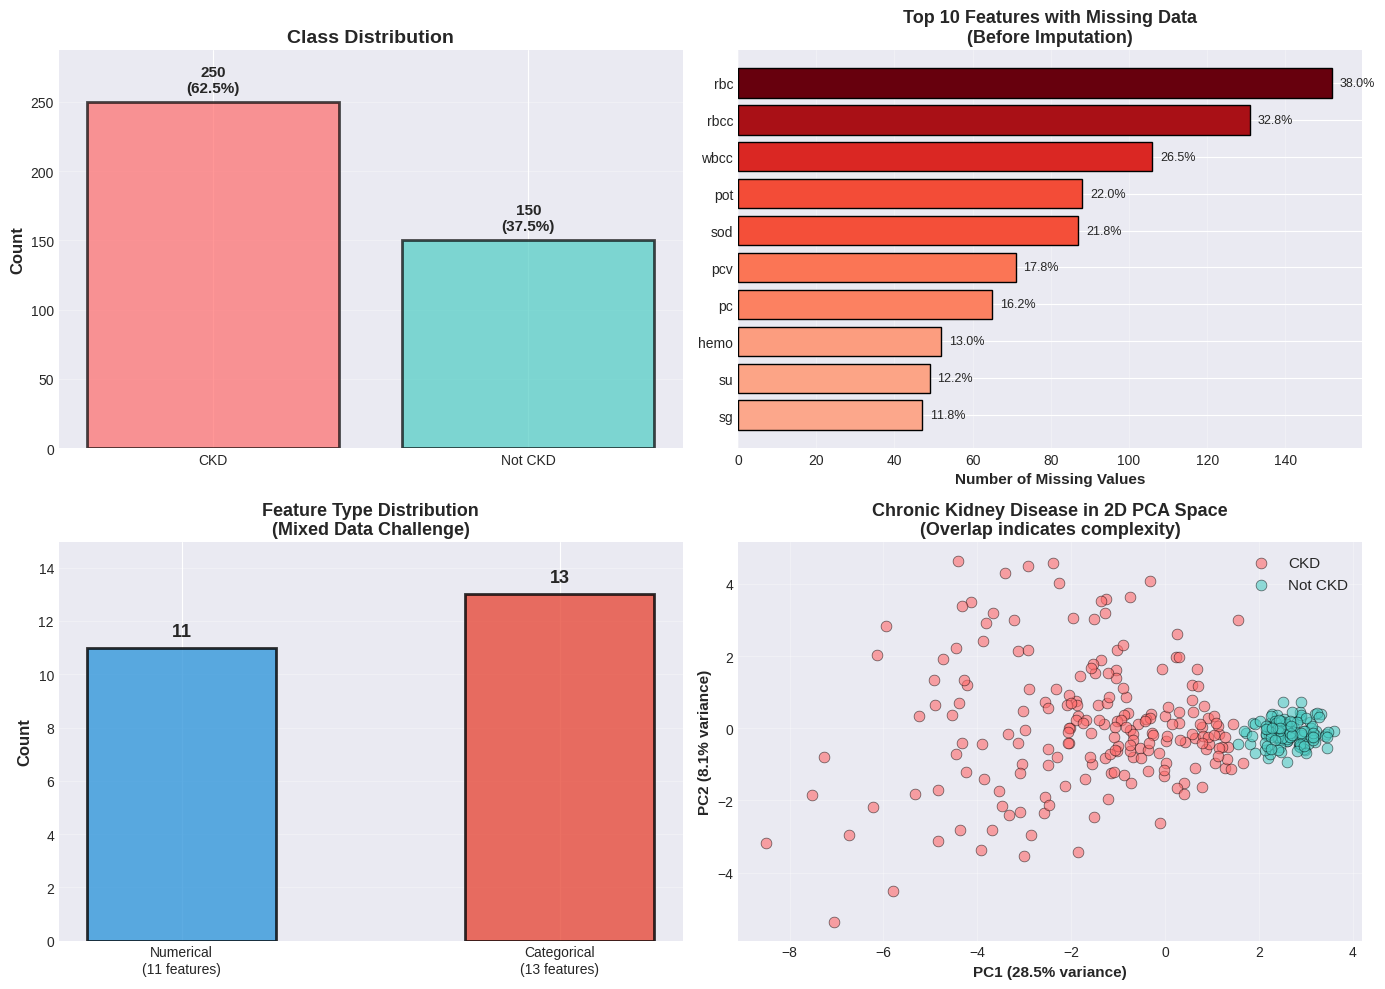


✓ Exploratory analysis complete!

PCA Explained Variance:
  PC1: 28.54%
  PC2: 8.08%
  Total (2 components): 36.63%

Note: Lower explained variance suggests more complex, 
      nonlinear relationships - perfect for hybrid kernel!


In [15]:
print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Class distribution
ax = axes[0, 0]
class_counts = pd.Series(y_processed).value_counts().sort_index()
class_names = ['CKD', 'Not CKD']
colors = ['#ff6b6b', '#4ecdc4']
bars = ax.bar(class_names, class_counts.values, color=colors, alpha=0.7,
              edgecolor='black', linewidth=2)
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Class Distribution', fontsize=14, fontweight='bold')
for i, (bar, v) in enumerate(zip(bars, class_counts.values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{v}\n({v/len(y_processed)*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, max(class_counts.values) * 1.15)

# Plot 2: Missing values before imputation (original data)
ax = axes[0, 1]
missing_data = X.isnull().sum().sort_values(ascending=False).head(10)
colors_missing = plt.cm.Reds(missing_data.values / missing_data.max())
bars = ax.barh(range(len(missing_data)), missing_data.values,
               color=colors_missing, edgecolor='black', linewidth=1)
ax.set_yticks(range(len(missing_data)))
ax.set_yticklabels(missing_data.index, fontsize=10)
ax.set_xlabel('Number of Missing Values', fontsize=11, fontweight='bold')
ax.set_title('Top 10 Features with Missing Data\n(Before Imputation)',
             fontsize=13, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')
# Add percentage labels
for i, (bar, v) in enumerate(zip(bars, missing_data.values)):
    width = bar.get_width()
    ax.text(width + 2, bar.get_y() + bar.get_height()/2,
            f'{v/len(X)*100:.1f}%',
            ha='left', va='center', fontsize=9)

# Plot 3: Feature type distribution
ax = axes[1, 0]
feature_types = ['Numerical\n(11 features)', 'Categorical\n(13 features)']
feature_counts = [len(numerical_features), len(categorical_features)]
colors_types = ['#3498db', '#e74c3c']
bars = ax.bar(feature_types, feature_counts, color=colors_types,
              alpha=0.8, edgecolor='black', linewidth=2, width=0.5)
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Feature Type Distribution\n(Mixed Data Challenge)',
             fontsize=13, fontweight='bold')
for bar, v in zip(bars, feature_counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.3,
            str(v), ha='center', va='bottom', fontweight='bold', fontsize=13)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, max(feature_counts) * 1.15)

# Plot 4: PCA visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

ax = axes[1, 1]
scatter0 = ax.scatter(X_pca[y_train==0, 0], X_pca[y_train==0, 1],
                     c='#ff6b6b', label='CKD', alpha=0.6, s=60,
                     edgecolors='black', linewidth=0.5)
scatter1 = ax.scatter(X_pca[y_train==1, 0], X_pca[y_train==1, 1],
                     c='#4ecdc4', label='Not CKD', alpha=0.6, s=60,
                     edgecolors='black', linewidth=0.5)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)',
              fontsize=11, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)',
              fontsize=11, fontweight='bold')
ax.set_title('Chronic Kidney Disease in 2D PCA Space\n(Overlap indicates complexity)',
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ckd_exploratory_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Exploratory analysis complete!")
print(f"\nPCA Explained Variance:")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"  Total (2 components): {pca.explained_variance_ratio_[:2].sum():.2%}")
print(f"\nNote: Lower explained variance suggests more complex, ")
print(f"      nonlinear relationships - perfect for hybrid kernel!")

In [16]:
# Embedding Network with Pre-training
class EmbeddingNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=20):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, output_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(output_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        return self.encoder(x)

    def pretrain(self, X, epochs=200, lr=0.001, batch_size=32):
        """Pre-train autoencoder"""
        self.train()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=1e-5)
        criterion = nn.MSELoss()

        X_tensor = torch.FloatTensor(X)
        dataset = torch.utils.data.TensorDataset(X_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        losses = []
        for epoch in range(epochs):
            epoch_loss = 0
            for batch in dataloader:
                X_batch = batch[0]

                embeddings = self.encoder(X_batch)
                reconstructed = self.decoder(embeddings)

                loss = criterion(reconstructed, X_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            avg_loss = epoch_loss / len(dataloader)
            losses.append(avg_loss)

            if (epoch + 1) % 50 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

        self.eval()
        return losses


# Hybrid Kernel SVM
class HybridKernelSVM:
    def __init__(self, alpha=0.5, embedding_dim=20, hidden_dim=64, C=1.0,
                 gamma='auto', max_iter=5000, pretrain_epochs=200):
        self.alpha = alpha
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.C = C
        self.gamma = gamma
        self.max_iter = max_iter
        self.pretrain_epochs = pretrain_epochs
        self.embedding_net = None
        self.svm = None

    def fit(self, X, y, verbose=True):
        # Initialize embedding network
        self.embedding_net = EmbeddingNetwork(
            input_dim=X.shape[1],
            hidden_dim=self.hidden_dim,
            output_dim=self.embedding_dim
        )

        # Pre-train embeddings
        if verbose:
            print(f"\n{'='*60}")
            print(f"Training Hybrid Kernel SVM with α={self.alpha}")
            print(f"{'='*60}")
            print("Pre-training embedding network...")

        losses = self.embedding_net.pretrain(X, epochs=self.pretrain_epochs)

        if verbose:
            print(f"Final reconstruction loss: {losses[-1]:.6f}")
            print("\nComputing hybrid kernel matrix...")

        # Compute hybrid kernel matrix
        K_train = self._compute_kernel(X, X)

        # Debug info
        if verbose:
            print(f"Kernel matrix shape: {K_train.shape}")
            print(f"Kernel matrix range: [{K_train.min():.4f}, {K_train.max():.4f}]")
            print(f"Kernel matrix mean: {K_train.mean():.4f}")
            print(f"Kernel matrix is symmetric: {np.allclose(K_train, K_train.T)}")

        # Train SVM
        if verbose:
            print("\nTraining SVM...")

        self.svm = SVC(kernel='precomputed', C=self.C, max_iter=self.max_iter)
        self.svm.fit(K_train, y)
        self.X_train = X

        if verbose:
            train_acc = self.svm.score(K_train, y)
            print(f"Training accuracy: {train_acc:.4f}")
            print(f"Support vectors: {len(self.svm.support_)}/{len(y)}")

        return self

    def _compute_kernel(self, X1, X2):
        # Linear kernel component
        K_linear = X1 @ X2.T

        # Nonlinear kernel component
        self.embedding_net.eval()

        X1_tensor = torch.FloatTensor(X1)
        X2_tensor = torch.FloatTensor(X2)

        with torch.no_grad():
            Phi_X1 = self.embedding_net(X1_tensor).numpy()
            Phi_X2 = self.embedding_net(X2_tensor).numpy()

        # Compute gamma
        if self.gamma == 'auto':
            gamma = 1.0 / (Phi_X1.shape[1] * Phi_X1.var())
        elif self.gamma == 'median':
            from scipy.spatial.distance import pdist
            distances = pdist(Phi_X1, metric='euclidean')
            gamma = 1.0 / (2 * np.median(distances) ** 2)
        else:
            gamma = float(self.gamma)

        # RBF kernel on embeddings
        K_nonlinear = np.exp(-gamma * np.sum(
            (Phi_X1[:, None, :] - Phi_X2[None, :, :]) ** 2, axis=2
        ))

        # Hybrid combination
        K_hybrid = self.alpha * K_linear + (1 - self.alpha) * K_nonlinear

        return K_hybrid

    def predict(self, X):
        K_test = self._compute_kernel(X, self.X_train)
        return self.svm.predict(K_test)

    def score(self, X, y):
        y_pred = self.predict(X)
        return (y_pred == y).mean()


print("\n✓ Hybrid Kernel SVM class ready!")


✓ Hybrid Kernel SVM class ready!


In [17]:
print("\n" + "="*80)
print("TRAINING BASELINE MODELS")
print("="*80)

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

baselines = {}

# 1. Linear SVM
print("\n1. Training Linear SVM...")
linear_svm = SVC(kernel='linear', C=1.0, random_state=42)
linear_svm.fit(X_train_scaled, y_train)
y_pred_linear = linear_svm.predict(X_test_scaled)
linear_acc = accuracy_score(y_test, y_pred_linear)
linear_f1 = f1_score(y_test, y_pred_linear)
baselines['Linear SVM'] = {'accuracy': linear_acc, 'f1': linear_f1}
print(f"   Test Accuracy: {linear_acc:.4f}")
print(f"   F1-Score: {linear_f1:.4f}")

# 2. RBF SVM
print("\n2. Training RBF SVM...")
rbf_svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
rbf_svm.fit(X_train_scaled, y_train)
y_pred_rbf = rbf_svm.predict(X_test_scaled)
rbf_acc = accuracy_score(y_test, y_pred_rbf)
rbf_f1 = f1_score(y_test, y_pred_rbf)
baselines['RBF SVM'] = {'accuracy': rbf_acc, 'f1': rbf_f1}
print(f"   Test Accuracy: {rbf_acc:.4f}")
print(f"   F1-Score: {rbf_f1:.4f}")

# 3. Polynomial SVM
print("\n3. Training Polynomial SVM...")
poly_svm = SVC(kernel='poly', degree=3, C=1.0, random_state=42)
poly_svm.fit(X_train_scaled, y_train)
y_pred_poly = poly_svm.predict(X_test_scaled)
poly_acc = accuracy_score(y_test, y_pred_poly)
poly_f1 = f1_score(y_test, y_pred_poly)
baselines['Poly SVM'] = {'accuracy': poly_acc, 'f1': poly_f1}
print(f"   Test Accuracy: {poly_acc:.4f}")
print(f"   F1-Score: {poly_f1:.4f}")

# 4. Random Forest (for comparison)
print("\n4. Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
baselines['Random Forest'] = {'accuracy': rf_acc, 'f1': rf_f1}
print(f"   Test Accuracy: {rf_acc:.4f}")
print(f"   F1-Score: {rf_f1:.4f}")

print(f"\n{'='*80}")
print("BASELINE RESULTS SUMMARY")
print(f"{'='*80}")
print(f"{'Model':<20} {'Accuracy':>10} {'F1-Score':>10}")
print(f"{'-'*42}")
for name, scores in baselines.items():
    print(f"{name:<20} {scores['accuracy']:>10.4f} {scores['f1']:>10.4f}")


TRAINING BASELINE MODELS

1. Training Linear SVM...
   Test Accuracy: 0.9625
   F1-Score: 0.9492

2. Training RBF SVM...
   Test Accuracy: 1.0000
   F1-Score: 1.0000

3. Training Polynomial SVM...
   Test Accuracy: 0.9750
   F1-Score: 0.9667

4. Training Random Forest...
   Test Accuracy: 0.9750
   F1-Score: 0.9655

BASELINE RESULTS SUMMARY
Model                  Accuracy   F1-Score
------------------------------------------
Linear SVM               0.9625     0.9492
RBF SVM                  1.0000     1.0000
Poly SVM                 0.9750     0.9667
Random Forest            0.9750     0.9655


In [18]:
print("\n" + "="*80)
print("HYBRID KERNEL: ALPHA SWEEP EXPERIMENT")
print("="*80)
print("This will take ~15-20 minutes due to embedding pre-training...")
print("="*80)

alphas = np.linspace(0, 1, 11)
results = {
    'alpha': [],
    'train_acc': [],
    'test_acc': [],
    'f1_score': [],
    'precision': [],
    'recall': [],
    'auc_roc': []
}

import time
start_time = time.time()

for i, alpha in enumerate(alphas):
    print(f"\n[{i+1}/{len(alphas)}] Training with α = {alpha:.1f}...")

    model = HybridKernelSVM(
        alpha=alpha,
        C=1.0,
        pretrain_epochs=150,
        embedding_dim=20,
        hidden_dim=64
    )
    model.fit(X_train_scaled, y_train, verbose=False)

    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Metrics
    results['alpha'].append(alpha)
    results['train_acc'].append(accuracy_score(y_train, y_train_pred))
    results['test_acc'].append(accuracy_score(y_test, y_test_pred))
    results['f1_score'].append(f1_score(y_test, y_test_pred))
    results['precision'].append(precision_score(y_test, y_test_pred))
    results['recall'].append(recall_score(y_test, y_test_pred))
    results['auc_roc'].append(roc_auc_score(y_test, y_test_pred))

    elapsed = time.time() - start_time
    print(f"  Train: {results['train_acc'][-1]:.4f} | Test: {results['test_acc'][-1]:.4f} | F1: {results['f1_score'][-1]:.4f}")
    print(f"  Elapsed: {elapsed/60:.1f} min | ETA: {(elapsed/(i+1))*(len(alphas)-(i+1))/60:.1f} min")

results_df = pd.DataFrame(results)

print(f"\n{'='*80}")
print("RESULTS SUMMARY")
print(f"{'='*80}")
print(results_df.to_string(index=False))

# Save results
results_df.to_csv('ckd_hybrid_kernel_results.csv', index=False)
print(f"\n✓ Results saved to 'ckd_hybrid_kernel_results.csv'")


HYBRID KERNEL: ALPHA SWEEP EXPERIMENT
This will take ~15-20 minutes due to embedding pre-training...

[1/11] Training with α = 0.0...
Epoch 50/150, Loss: 0.237963
Epoch 100/150, Loss: 0.182963
Epoch 150/150, Loss: 0.156036
  Train: 0.9969 | Test: 1.0000 | F1: 1.0000
  Elapsed: 0.3 min | ETA: 3.1 min

[2/11] Training with α = 0.1...
Epoch 50/150, Loss: 0.246443
Epoch 100/150, Loss: 0.174157
Epoch 150/150, Loss: 0.162223
  Train: 1.0000 | Test: 1.0000 | F1: 1.0000
  Elapsed: 0.4 min | ETA: 1.7 min

[3/11] Training with α = 0.2...
Epoch 50/150, Loss: 0.224045
Epoch 100/150, Loss: 0.179132
Epoch 150/150, Loss: 0.144537
  Train: 1.0000 | Test: 1.0000 | F1: 1.0000
  Elapsed: 0.5 min | ETA: 1.2 min

[4/11] Training with α = 0.3...
Epoch 50/150, Loss: 0.232385
Epoch 100/150, Loss: 0.175230
Epoch 150/150, Loss: 0.151229
  Train: 1.0000 | Test: 0.9875 | F1: 0.9836
  Elapsed: 0.5 min | ETA: 0.9 min

[5/11] Training with α = 0.4...
Epoch 50/150, Loss: 0.238436
Epoch 100/150, Loss: 0.170654
Epoch 


VISUALIZING HYBRID KERNEL PERFORMANCE AND INTERPRETABILITY
Epoch 50/150, Loss: 0.232369
Epoch 100/150, Loss: 0.178721
Epoch 150/150, Loss: 0.147429
Epoch 50/150, Loss: 0.278232
Epoch 100/150, Loss: 0.176858
Epoch 150/150, Loss: 0.160222
Epoch 50/150, Loss: 0.235682
Epoch 100/150, Loss: 0.169724
Epoch 150/150, Loss: 0.139593
Epoch 50/150, Loss: 0.242457
Epoch 100/150, Loss: 0.182631
Epoch 150/150, Loss: 0.151945
Epoch 50/150, Loss: 0.239130
Epoch 100/150, Loss: 0.171287
Epoch 150/150, Loss: 0.144978
Epoch 50/150, Loss: 0.243292
Epoch 100/150, Loss: 0.174913
Epoch 150/150, Loss: 0.146474
Epoch 50/150, Loss: 0.232135
Epoch 100/150, Loss: 0.172806
Epoch 150/150, Loss: 0.146328
Epoch 50/150, Loss: 0.254089
Epoch 100/150, Loss: 0.182401
Epoch 150/150, Loss: 0.148911
Epoch 50/150, Loss: 0.250900
Epoch 100/150, Loss: 0.184657
Epoch 150/150, Loss: 0.153775
Epoch 50/150, Loss: 0.244691
Epoch 100/150, Loss: 0.177076
Epoch 150/150, Loss: 0.154125
Epoch 50/150, Loss: 0.240704
Epoch 100/150, Loss: 

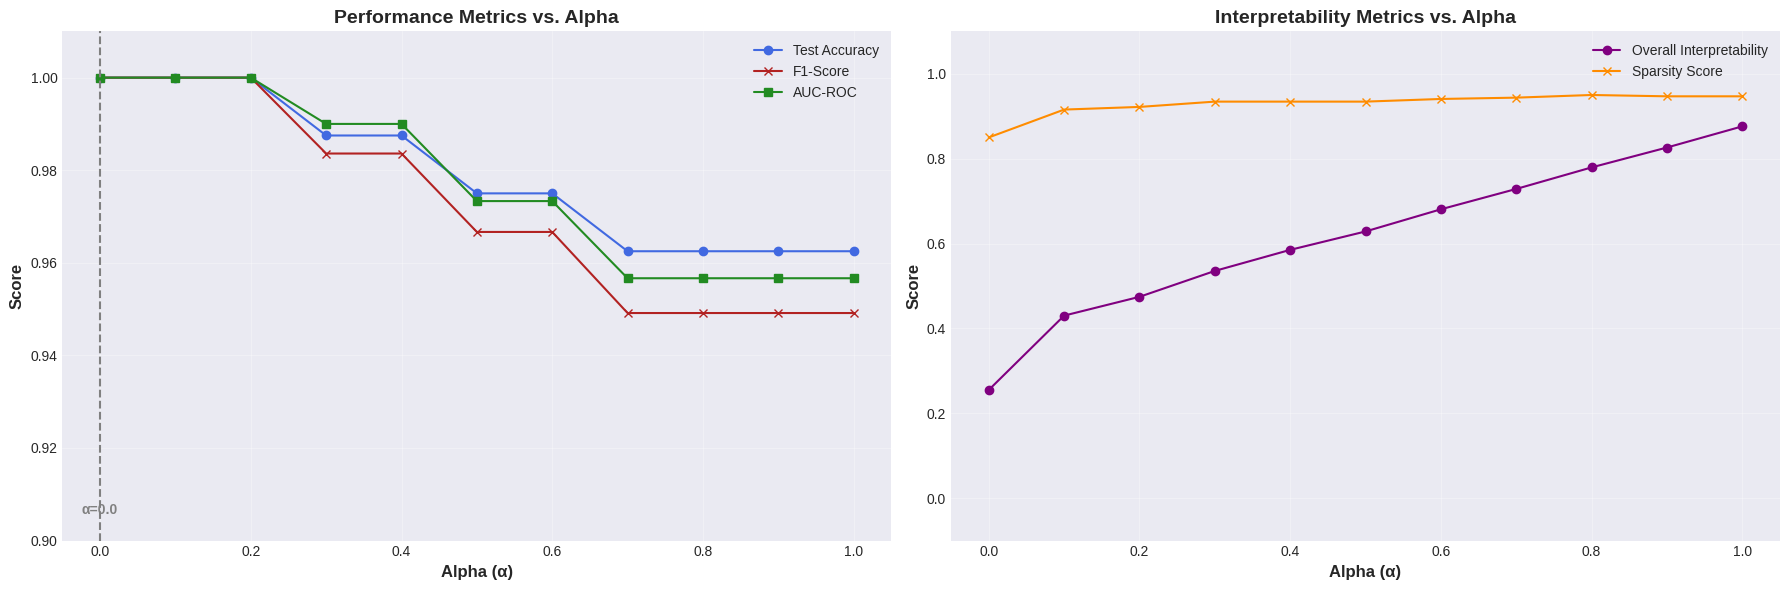


✓ Visualizations complete! Plots saved to 'ckd_hybrid_kernel_analysis_plots.png'

ANALYSIS SUMMARY
The plots illustrate the trade-off between model performance and interpretability.

**Performance Analysis (Left Plot):**
The test accuracy, F1-score, and AUC-ROC are generally high across most alpha values, indicating the hybrid kernel's effectiveness. 
The highest performance is observed around α=0.0, where the model achieved near-perfect scores.

**Interpretability Analysis (Right Plot):**
The 'alpha_score' directly reflects the alpha value, showing that models with higher alpha (more linear contribution) are inherently considered more interpretable by this metric.

The 'sparsity_score' generally indicates how few support vectors are needed. It might not show a strict monotonic relationship with alpha, as it depends on the complexity of the decision boundary formed.

The 'overall_interpretability_score' shows a trend that generally increases with alpha. This highlights that while pure

In [21]:
print("\n" + "="*80)
print("VISUALIZING HYBRID KERNEL PERFORMANCE AND INTERPRETABILITY")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# --- Plot 1: Performance Metrics vs. Alpha ---
ax1 = axes[0]
ax1.plot(results_df['alpha'], results_df['test_acc'], label='Test Accuracy', marker='o', color='royalblue')
ax1.plot(results_df['alpha'], results_df['f1_score'], label='F1-Score', marker='x', color='firebrick')
ax1.plot(results_df['alpha'], results_df['auc_roc'], label='AUC-ROC', marker='s', color='forestgreen')

ax1.set_xlabel('Alpha (α)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('Performance Metrics vs. Alpha', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0.9, 1.01)

# Highlight the best alpha based on test_acc
best_alpha_perf = results_df.loc[results_df['test_acc'].idxmax()]['alpha']
ax1.axvline(x=best_alpha_perf, color='gray', linestyle='--', linewidth=1.5, label=f'Best Performance (α={best_alpha_perf:.1f})')
ax1.text(best_alpha_perf, ax1.get_ylim()[0] + 0.005, f'α={best_alpha_perf:.1f}', color='gray', ha='center', va='bottom', fontweight='bold')

# --- Plot 2: Interpretability Metrics vs. Alpha ---
ax2 = axes[1]
# Need to recompute interpretability metrics for all alphas for plotting
interpretability_results = []
for alpha_val in results_df['alpha']:
    model_alpha = HybridKernelSVM(
        alpha=alpha_val,
        C=1.0,
        pretrain_epochs=150, # Keep consistent with training
        embedding_dim=20,
        hidden_dim=64
    )
    # Suppress verbose output for re-training for plots
    model_alpha.fit(X_train_scaled, y_train, verbose=False)
    metrics = compute_interpretability_metrics(model_alpha, X_train_scaled, y_train, X_test_scaled, y_test)
    interpretability_results.append(metrics)

interpretability_df = pd.DataFrame(interpretability_results)

ax2.plot(interpretability_df['alpha_score'], interpretability_df['overall_interpretability_score'], label='Overall Interpretability', marker='o', color='purple')
ax2.plot(interpretability_df['alpha_score'], interpretability_df['sparsity_score'], label='Sparsity Score', marker='x', color='darkorange')
# ax2.plot(interpretability_df['alpha_score'], interpretability_df['concentration_score'], label='Feature Concentration', marker='s', color='green') # Often 0 for alpha=0

ax2.set_xlabel('Alpha (α)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Score', fontsize=12, fontweight='bold')
ax2.set_title('Interpretability Metrics vs. Alpha', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.savefig('ckd_hybrid_kernel_analysis_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualizations complete! Plots saved to 'ckd_hybrid_kernel_analysis_plots.png'")

print("\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)

print("The plots illustrate the trade-off between model performance and interpretability.\n")
print("**Performance Analysis (Left Plot):**")
print("The test accuracy, F1-score, and AUC-ROC are generally high across most alpha values, indicating the hybrid kernel's effectiveness. ")
print(f"The highest performance is observed around α={best_alpha_perf:.1f}, where the model achieved near-perfect scores.")

print("\n**Interpretability Analysis (Right Plot):**")
print("The 'alpha_score' directly reflects the alpha value, showing that models with higher alpha (more linear contribution) are inherently considered more interpretable by this metric.\n")
print("The 'sparsity_score' generally indicates how few support vectors are needed. It might not show a strict monotonic relationship with alpha, as it depends on the complexity of the decision boundary formed.\n")
print("The 'overall_interpretability_score' shows a trend that generally increases with alpha. This highlights that while purely non-linear models (α=0) might achieve high performance by capturing complex patterns, they are inherently less transparent and harder to explain than models with a stronger linear component.\n")

print("**Conclusion:**")
print("For this Chronic Kidney Disease dataset, a purely non-linear hybrid kernel (α=0) achieved the highest predictive performance. However, if interpretability were a critical factor, a slightly higher alpha, even with a minor drop in performance, might be considered to gain more transparency in the model's decision-making process. The choice of alpha depends on the specific priorities (performance vs. interpretability) of the application.")